<div align="right">Peter Norvig<br>March 2019</div>

# Dice Baseball

The [March 22, 2019 Riddler](https://fivethirtyeight.com/features/can-you-turn-americas-pastime-into-a-game-of-yahtzee/) asks us to simulate baseball using probabilities from a 19th century dice game. The simulation is pretty straightforward. (Note that I chose not to implement a strike as an event, but rather to count the probability of getting 3 strikes in a row, and calling that an event.)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
from statistics import mean
import random

In [2]:
def inning(events='2111111EEBBOOooooooofffffD334', strikes=7*'s', verbose=False):
    "Play a random inning and return number of runs scored."
    assert len(events) + len(strikes) == 6 * 6
    K = (len(strikes) / len(strikes+events)) ** 3 # The probability of a strikeout
    events = events.replace('E', '1') # An error is the same as a single
    outs = runs = 0
    runners = [] # A list of runners; [1, 2, 3] means bases loaded
    while True:
        x = 'K' if random.random() <= K else random.choice(events)
        if verbose: 
            print('{} outs; {} runs; runners on {}; result is {}'
                  .format(outs, runs, runners, x))
        if x in '1234': # single, double, triple, homer
            runners = [r + int(x) + (r == 2) for r in runners + [0]]
        elif x == 'B': # base on balls
            runners = [(r+1 if r==1 or r-1 in runners else r) for r in runners] + [1]
        elif x in 'KOofD': # srikeout, foul out, out at first, fly out, double play
            outs += 1
            if x == 'D' and runners: # double play
                runners.remove(min(runners))
                outs += 1
            elif x == 'o': # out at first (other runners advance)
                runners = [r+1 for r in runners]
            elif x == 'f' and 3 in runners: # fly out; runner on 3rd scores
                runs += 1
                runners.remove(3)
        else:
            raise ValueError('unknown events: ' + x)
        if outs >= 3:
            return runs
        else: # See if anybody scored
            runs += sum(r >= 4 for r in runners)
            runners = [r for r in runners if r < 4]

Let's peek at some random innings:

In [3]:
inning(verbose=True)

0 outs; 0 runs; runners on []; result is o
1 outs; 0 runs; runners on []; result is o
2 outs; 0 runs; runners on []; result is 1
2 outs; 0 runs; runners on [1]; result is 1
2 outs; 0 runs; runners on [2, 1]; result is O


0

In [4]:
inning(verbose=True)

0 outs; 0 runs; runners on []; result is 3
0 outs; 0 runs; runners on [3]; result is f
1 outs; 1 runs; runners on []; result is 1
1 outs; 1 runs; runners on [1]; result is o
2 outs; 1 runs; runners on [2]; result is 1
2 outs; 2 runs; runners on [1]; result is 1
2 outs; 2 runs; runners on [2, 1]; result is K


2

In [5]:
inning(verbose=True)

0 outs; 0 runs; runners on []; result is o
1 outs; 0 runs; runners on []; result is 3
1 outs; 0 runs; runners on [3]; result is D


0

That looks good.

Now, simulate a million innings, use them to simulate a million games, and show a histogram of runs scored per team per game:

In [6]:
%%time
N = 1000000
innings = [inning() for _ in range(N)]
games = [sum(random.choice(innings) for i in range(9)) for g in range(N)]

CPU times: user 20.7 s, sys: 73.7 ms, total: 20.8 s
Wall time: 20.9 s


(15.106058, 15.10542)

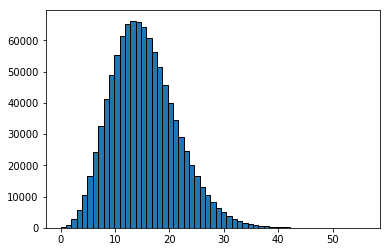

In [7]:
plt.hist(games, ec='black', bins=max(games)-min(games)+1)
mean(games), mean(innings) * 9